Libraries import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import ViTHybridImageProcessor, ViTHybridForImageClassification
from transformers import AutoImageProcessor, SwinForImageClassification
from transformers import ViTImageProcessor, ViTForImageClassification
from sklearn.metrics import roc_curve
from PIL import Image
import requests
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import torch

excluded_dataset = 'msu' #msu done

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using device: cuda


SWIN transformer definition

In [2]:
swin_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
swin_model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [3]:
# Define a binary classification head
class BinaryClassificationHead(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BinaryClassificationHead, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Modify the Swin Transformer model for binary classification
swin_classifier_head = BinaryClassificationHead(768, 32)  # Adjust input size as needed
swin_model.classifier = swin_classifier_head

# Define loss function and optimizer
swin_criterion = nn.BCEWithLogitsLoss()
swin_optimizer = optim.AdamW(swin_model.parameters(), lr=1e-4)

VIT transformer definition

In [4]:
vit_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [5]:
# Modify the Swin Transformer model for binary classification
vit_classifier_head = BinaryClassificationHead(768, 32)  # Adjust input size as needed
vit_model.classifier = vit_classifier_head

# Define loss function and optimizer
vit_criterion = nn.BCEWithLogitsLoss()
vit_optimizer = optim.AdamW(vit_model.parameters(), lr=1e-4)

Dataset loading

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, DataLoader, Subset, random_split
import os
import torch

def load_and_shuffle_dataset(root_path, subfolders, transform):
    my_datasets = [
        datasets.ImageFolder(os.path.join(root_path, folder, 'train'), transform=transform) +
        datasets.ImageFolder(os.path.join(root_path, folder, 'test'), transform=transform)
        for folder in subfolders
    ]
    # Shuffle each dataset
    for i in range(len(my_datasets)):
        indices = torch.randperm(len(my_datasets[i])).tolist()
        my_datasets[i] = Subset(my_datasets[i], indices)
    return my_datasets

def split_dataset(dataset, ratios):
    """ Splits a dataset into parts according to the given ratios. """
    total_size = len(dataset)
    lengths = [int(ratio * total_size) for ratio in ratios]
    # Ensure the sum of lengths is equal to the total size
    lengths[-1] = total_size - sum(lengths[:-1])
    return random_split(dataset, lengths)

import random
from PIL import Image
from torchvision import transforms

# Define custom rotation function
def random_rotation(image):
    rotation_angle = random.choice([0, 90, 180, 270])
    return image.rotate(rotation_angle)

# Define transformations
transform = transforms.Compose([
    transforms.Pad(25, padding_mode='symmetric'),
    transforms.RandomHorizontalFlip(), 
    transforms.Lambda(lambda img: random_rotation(img)),  # Custom rotation
    transforms.ColorJitter([1, 1]),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and shuffle datasets
datasets_list = set(['casia', 'oulu', 'replay', 'msu'])
# datasets_list = set(['oulu', 'replay', 'msu'])

exclude = set([excluded_dataset])
my_datasets = load_and_shuffle_dataset('/kaggle/input/face-presentation-attacks-datasets/data_crop/', list(datasets_list.difference(exclude)), transform)

# Load and shuffle test dataset
test_dataset = datasets.ImageFolder(f'/kaggle/input/face-presentation-attacks-datasets/data_crop//{list(exclude)[0]}/test', transform=transform)
indices = torch.randperm(len(test_dataset)).tolist()
test_dataset = Subset(test_dataset, indices)

# Split test dataset into three equal parts
#test_partitions = random_split(test_dataset, [len(test_dataset) // 3] * 2 + [len(test_dataset) - 2 * (len(test_dataset) // 3)])

ratios = [0.33, 0.33, 0.34]

partitions = [[], [], []]
for dataset in my_datasets:
    parts = split_dataset(dataset, ratios)
    for i, part in enumerate(parts):
        partitions[i].append(part)

# Combine corresponding parts from different datasets
combined_partitions = [ConcatDataset(partition) for partition in partitions]

# Further split each combined partition into train and val sets
final_ratios = [0.8, 0.2]  # Ratios for train and val
loaders = []

batch_size = 16

for partition in combined_partitions:
    train_part, val_part = split_dataset(partition, final_ratios)
    train_loader = DataLoader(train_part, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_part, batch_size=batch_size, shuffle=False)
    loaders.append((train_loader, val_loader))

# Combine all datasets into one
combined_dataset = ConcatDataset(my_datasets)

# Split the combined dataset into training and validation sets
train_dataset, val_dataset = split_dataset(combined_dataset, final_ratios)

# Create Data Loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_loader1, val_loader1 = loaders[0]
train_loader2, val_loader2 = loaders[1]
train_loader3, val_loader3 = loaders[2]

# Create Test Loaders
# test_loaders = [DataLoader(test_part, batch_size=batch_size, shuffle=False) for test_part in test_partitions]
test_loaders = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# test_loader1, test_loader2, test_loader3 = test_loaders
test_loader, test_loader2, test_loader3 = test_loaders, test_loaders, test_loaders

SWIN transformer training

Epoch 1, Training Loss: 0.2697382031670769, Validation Loss: 0.048146287036337415
Epoch 2, Training Loss: 0.07795094100751288, Validation Loss: 0.027276549767762212
Epoch 3, Training Loss: 0.047298185788924196, Validation Loss: 0.016151103998263538
Epoch 4, Training Loss: 0.03517316802264661, Validation Loss: 0.0635178529972814
Epoch 5, Training Loss: 0.03971190841276692, Validation Loss: 0.021495792041271354
Epoch 6, Training Loss: 0.023769186641949113, Validation Loss: 0.010834857092458133
Epoch 7, Training Loss: 0.026067721938295766, Validation Loss: 0.04280460963847724
Epoch 8, Training Loss: 0.023746891907481638, Validation Loss: 0.011011547247293568
Epoch 9, Training Loss: 0.0365120057943356, Validation Loss: 0.0228843855961435
Epoch 10, Training Loss: 0.02404012171965217, Validation Loss: 0.00790278503646565
Epoch 11, Training Loss: 0.03988839621782405, Validation Loss: 0.007700886376610748
Epoch 12, Training Loss: 0.029375305135456813, Validation Loss: 0.019131497468523016
Epoc

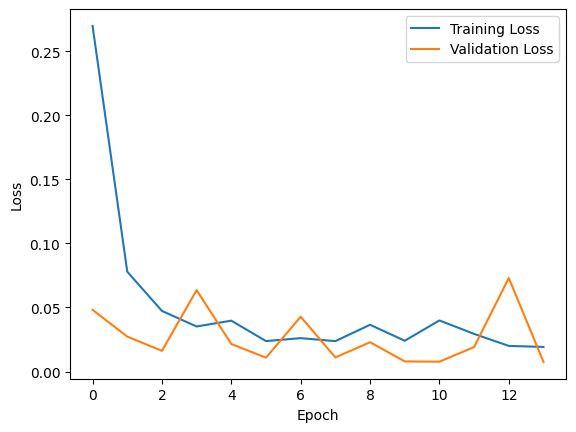

In [7]:
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
swin_model.to(device)

# Initialize early stopping parameters
patience = 5
verbose = True
delta = 0.001  # Set an appropriate delta value
best_val_loss = float('inf')
counter = 0

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    swin_model.train()
    running_loss = 0.0
    for data, labels in train_loader1:
        data, labels = data.to(device), labels.to(device)
        swin_optimizer.zero_grad()
        outputs = swin_model(data).logits
        loss = swin_criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        swin_optimizer.step()
        running_loss += loss.item()

    # Validation
    swin_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_data, val_labels in val_loader1:
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            val_outputs = swin_model(val_data).logits
            val_loss += swin_criterion(val_outputs, val_labels.unsqueeze(1).float()).item()

    avg_train_loss = running_loss / len(train_loader1)
    avg_val_loss = val_loss / len(val_loader1)
    
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    # Early stopping
    if avg_val_loss < best_val_loss - delta:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch+1}")
            break

    # Save the model if validation loss is improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(swin_model.state_dict(), 'best_swin_model.pth')

    # Append losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

# Plotting the training and validation curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Validation set for EER calculation
swin_model.eval()
val_labels, val_scores = [], []

with torch.no_grad():
    for data, labels in val_loader2:
        data, labels = data.to(device), labels.to(device)
        outputs = swin_model(data).logits
        val_labels.extend(labels.cpu().numpy())
        val_scores.extend(torch.sigmoid(outputs).cpu().numpy())

# Calculate Equal Error Rate (EER) on the validation set
fpr, tpr, thresholds = roc_curve(val_labels, val_scores, pos_label=1)
eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
eer = 1 - tpr[np.argmin(np.abs(tpr - (1 - fpr)))]
print(f'Validation EER: {eer*100:.4f}, EER Threshold: {eer_threshold:.4f}')

Validation EER: 0.3205, EER Threshold: 0.7741


In [9]:
# Initialize lists to store test scores and labels
test_labels, test_scores = [], []

# Make predictions on the test set
swin_model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = swin_model(data).logits
        test_labels.extend(labels.cpu().numpy())
        test_scores.extend(torch.sigmoid(outputs).cpu().numpy())

# Calculate the HTER on the testing set using the EER threshold
threshold = eer_threshold
predicted_labels = [1 if score > threshold else 0 for score in test_scores]

false_acceptance = sum(1 for i in range(len(predicted_labels)) if predicted_labels[i] == 1 and test_labels[i] == 0)
false_rejection = sum(1 for i in range(len(predicted_labels)) if predicted_labels[i] == 0 and test_labels[i] == 1)

total_samples = len(test_labels)
hter = ((false_acceptance + false_rejection) / (2 * total_samples)) * 100
print(f"SWIN HTER: {hter:.2f}%")


SWIN HTER: 6.08%


In [10]:
# Calculate the AUC on the testing set
auc_score = roc_auc_score(test_labels, test_scores)
print(f"SWIN AUC on the testing set: {auc_score*100:.2f}")

SWIN AUC on the testing set: 95.64


VIT transformer training

Epoch 1, Training Loss: 0.16892687468718062, Validation Loss: 0.03289442628679075
Epoch 2, Training Loss: 0.049867736714858744, Validation Loss: 0.0455995827125699
Epoch 3, Training Loss: 0.029902932744579214, Validation Loss: 0.007240340430218232
Epoch 4, Training Loss: 0.030386511529923853, Validation Loss: 0.047255063437790214
Epoch 5, Training Loss: 0.03260342163942478, Validation Loss: 0.01219327441815819
Epoch 6, Training Loss: 0.03016361487989762, Validation Loss: 0.0223427882598599
Epoch 7, Training Loss: 0.00980396141741595, Validation Loss: 0.001763458911932967
Epoch 8, Training Loss: 0.01882087743790943, Validation Loss: 0.02229985724172403
Epoch 9, Training Loss: 0.01649925900038744, Validation Loss: 0.05449620511962519
Epoch 10, Training Loss: 0.0201966545544267, Validation Loss: 0.004513966450758744
Epoch 11, Training Loss: 0.01816879645260313, Validation Loss: 0.654416420887526
Epoch 12, Training Loss: 0.01840958539976368, Validation Loss: 0.04903979045344868
Early stopp

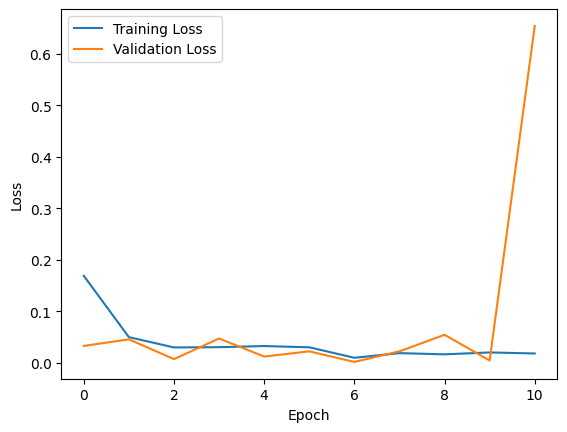

In [11]:
# Assuming model, train_loader, val_loader, criterion, and optimizer are defined

num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model.to(device)

# Initialize early stopping parameters
patience = 5
verbose = True
delta = 0.001  # Set an appropriate delta value
best_val_loss = float('inf')
counter = 0

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    for data, labels in train_loader2:
        data, labels = data.to(device), labels.to(device)
        vit_optimizer.zero_grad()
        outputs = vit_model(data).logits
        loss = vit_criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        vit_optimizer.step()
        running_loss += loss.item()

    # Validation
    vit_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_data, val_labels in val_loader2:
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            val_outputs = vit_model(val_data).logits
            val_loss += vit_criterion(val_outputs, val_labels.unsqueeze(1).float()).item()

    avg_train_loss = running_loss / len(train_loader2)
    avg_val_loss = val_loss / len(val_loader2)
    
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    # Early stopping
    if avg_val_loss < best_val_loss - delta:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch+1}")
            break

    # Save the model if validation loss is improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(vit_model.state_dict(), 'best_vit_model.pth')

    # Append losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

# Plotting the training and validation curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Validation set for EER calculation
vit_model.eval()
val_labels, val_scores = [], []

with torch.no_grad():
    for data, labels in val_loader2:
        data, labels = data.to(device), labels.to(device)
        outputs = vit_model(data).logits
        val_labels.extend(labels.cpu().numpy())
        val_scores.extend(torch.sigmoid(outputs).cpu().numpy())


# Calculate Equal Error Rate (EER) on the validation set
fpr, tpr, thresholds = roc_curve(val_labels, val_scores, pos_label=1)
eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
eer = 1 - tpr[np.argmin(np.abs(tpr - (1 - fpr)))]
print(f'VIT Validation EER: {eer*100:.4f}, EER Threshold: {eer_threshold:.4f}')

VIT Validation EER: 0.9615, EER Threshold: 0.0240


In [13]:

# Initialize lists to store test scores and labels
test_labels, test_scores = [], []

# Make predictions on the test set
vit_model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = vit_model(data).logits
        test_labels.extend(labels.cpu().numpy())
        test_scores.extend(torch.sigmoid(outputs).cpu().numpy())

# Calculate the HTER on the testing set using the EER threshold
threshold = eer_threshold
predicted_labels = [1 if score > threshold else 0 for score in test_scores]

false_acceptance = sum(1 for i in range(len(predicted_labels)) if predicted_labels[i] == 1 and test_labels[i] == 0)
false_rejection = sum(1 for i in range(len(predicted_labels)) if predicted_labels[i] == 0 and test_labels[i] == 1)

total_samples = len(test_labels)
hter = ((false_acceptance + false_rejection) / (2 * total_samples)) * 100
print(f"VIT HTER using EER threshold: {hter:.2f}%")

VIT HTER using EER threshold: 8.99%


In [14]:
# Calculate the AUC on the testing set
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(test_labels, test_scores)
print(f"VIT AUC on the testing set: {auc_score*100:.2f}")

VIT AUC on the testing set: 85.35


Stacking model

In [15]:
# 

VGGNET

In [16]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# import torchvision.models as models
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score
# from scipy.optimize import brentq
# from scipy.interpolate import interp1d
# from sklearn.metrics import confusion_matrix
# from torchvision import datasets, transforms
# import numpy as np 
# import timm
# import torch.optim as optim
# import random
# from torch.optim import Adam
# import torch.nn as nn
# import torch.optim as optim
# import timm

# # Define your SimpleVGGNet model
# class SimpleVGGNet(nn.Module):
#     def __init__(self, num_classes):
#         super(SimpleVGGNet, self).__init__()
#         self.model = timm.create_model('vgg16', pretrained=True)  # You can use 'vgg16' or any other VGG variant

#         # Access the last linear layer of VGGNet
#         in_features = self.model.head.fc.in_features
#         self.model.head.fc = nn.Linear(in_features, num_classes)

#     def forward(self, x):
#         return self.model(x)

# # Instantiate the custom VGGNet model
# num_classes = 2  # Binary classification
# model = SimpleVGGNet(num_classes)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)  # You can use Adam optimizer if desired


# num_epochs =  10
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Initialize EER and threshold variables
# eer = None
# threshold = None


# # Define transformations
# transform = transforms.Compose([
#     transforms.Pad(25, padding_mode='symmetric'),
#     transforms.RandomHorizontalFlip(), 
#     transforms.RandomRotation(10),
#     transforms.ColorJitter([1,1]),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Load and shuffle datasets
# datasets_list = set(['casia', 'oulu', 'replay', 'msu'])
# exclude = set([excluded_dataset])
# my_datasets = load_and_shuffle_dataset('/kaggle/input/face-presentation-attacks-datasets/data_crop/', list(datasets_list.difference(exclude)), transform)

# # Load and shuffle test dataset
# test_dataset = datasets.ImageFolder(f'/kaggle/input/face-presentation-attacks-datasets/data_crop//{list(exclude)[0]}/test', transform=transform)
# indices = torch.randperm(len(test_dataset)).tolist()
# test_dataset = Subset(test_dataset, indices)

# # Split test dataset into three equal parts
# #test_partitions = random_split(test_dataset, [len(test_dataset) // 3] * 2 + [len(test_dataset) - 2 * (len(test_dataset) // 3)])

# ratios = [0.33, 0.33, 0.34]

# partitions = [[], [], []]
# for dataset in my_datasets:
#     parts = split_dataset(dataset, ratios)
#     for i, part in enumerate(parts):
#         partitions[i].append(part)

# # Combine corresponding parts from different datasets
# combined_partitions = [ConcatDataset(partition) for partition in partitions]

# # Further split each combined partition into train and val sets
# final_ratios = [0.8, 0.2]  # Ratios for train and val
# loaders = []

# batch_size = 32

# for partition in combined_partitions:
#     train_part, val_part = split_dataset(partition, final_ratios)
#     train_loader = DataLoader(train_part, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_part, batch_size=batch_size, shuffle=False)
#     loaders.append((train_loader, val_loader))

# # Combine all datasets into one
# combined_dataset = ConcatDataset(my_datasets)

# # Split the combined dataset into training and validation sets
# train_dataset, val_dataset = split_dataset(combined_dataset, final_ratios)

# # Create Data Loaders for training and validation sets
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# # Create Test Loaders
# # test_loaders = [DataLoader(test_part, batch_size=batch_size, shuffle=False) for test_part in test_partitions]
# test_loaders = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # test_loader1, test_loader2, test_loader3 = test_loaders
# test_loader, test_loader2, test_loader3 = test_loaders, test_loaders, test_loaders

# for epoch in range(num_epochs):
#     model.train()
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     # Validation loop
#     model.eval()

#     all_labels = []
#     all_scores = []

#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             outputs = model(inputs)
#             scores = torch.nn.functional.softmax(outputs, dim=1)[:, 1]

#             all_labels.extend(labels.cpu().numpy())
#             all_scores.extend(scores.cpu().numpy())

#     # Calculate EER once after training on the validation set
#     fpr, tpr, thresholds = roc_curve(all_labels, all_scores, pos_label=1)

#     # Check for NaN values in the arrays
#     if any(np.isnan(fpr)) or any(np.isnan(tpr)) or any(np.isnan(thresholds)):
#         print("Error: NaN values encountered in fpr, tpr, or thresholds during EER calculation.")
#         # Handle this case accordingly
#     else:
#         eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
#         threshold = thresholds[np.nanargmin(np.abs(fpr - eer))]

#         print(f"Epoch {epoch + 1}/{num_epochs}, Validation EER: {eer * 100:.2f}%")
#         print(f"Validation EER Threshold: {threshold:.4f}")
        
# if eer is not None and threshold is not None:
#     model.eval()

#     genuine_scores = []
#     impostor_scores = []
#     true_labels = []

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             scores_test = torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().detach().numpy()

#             true_labels.extend(labels.cpu().numpy())
#             impostor_scores.extend(scores_test[labels.cpu() == 0])  # Impostor scores
#             genuine_scores.extend(scores_test[labels.cpu() == 1])   # Genuine scores

#     # Apply threshold to impostor scores to get binary predictions
#     binary_predictions = (np.array(impostor_scores) > threshold).astype(int)

#     # Calculate FAR and FRR
#     false_acceptance = sum(binary_predictions) / len(binary_predictions)
#     false_rejection = sum(genuine_score <= threshold for genuine_score in genuine_scores) / len(genuine_scores)

#     # Calculate HTER
#     hter = 0.5 * (false_acceptance + false_rejection)

#     # Calculate AUC
#     auc = roc_auc_score(np.array(true_labels), np.concatenate([impostor_scores, genuine_scores]))

#     print(f"VGGNET Test HTER: {hter * 100:.2f}%")
#     print(f"VGGNET Test AUC: {auc:.4f}")
# else:
#     print("Error: EER and threshold not calculated during validation.")
#     # Calculate the AUC on the testing set
#     from sklearn.metrics import roc_auc_score
#     auc_score = roc_auc_score(labels, scores_test.cpu())
#     print(f"AUC on the testing set: {auc_score*100:.2f}")


RESNET

In [17]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# import torchvision.models as models
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score
# from scipy.optimize import brentq
# from scipy.interpolate import interp1d
# from sklearn.metrics import confusion_matrix
# from torchvision import datasets, transforms
# import numpy as np 
# import timm
# import torch.optim as optim
# import random
# from torch.optim import Adam

# import torch.nn as nn
# import torch.optim as optim
# import timm

# # Define your SimpleResNet101 model
# class SimpleResNet101(nn.Module):
#     def __init__(self, num_classes):
#         super(SimpleResNet101, self).__init__()
#         self.model = timm.create_model('resnet101', pretrained=True)  # You can use other ResNet variants if needed

#         # Modify the last fully connected layer of ResNet101
#         in_features = self.model.fc.in_features
#         self.model.fc = nn.Linear(in_features, num_classes)

#     def forward(self, x):
#         return self.model(x)

# # Instantiate the custom ResNet101 model
# num_classes = 2  # Binary classification
# resnet = SimpleResNet101(num_classes)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(resnet.parameters(), lr=0.001)  # You can use Adam optimizer if desired


# num_epochs =  5
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# resnet.to(device)

# # Initialize EER and threshold variables
# eer = None
# threshold = None

# for epoch in range(num_epochs):
#     resnet.train()
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = resnet(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     # Validation loop
#     resnet.eval()

#     all_labels = []
#     all_scores = []

#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             outputs = resnet(inputs)
#             scores = torch.nn.functional.softmax(outputs, dim=1)[:, 1]

#             all_labels.extend(labels.cpu().numpy())
#             all_scores.extend(scores.cpu().numpy())

#     # Calculate EER once after training on the validation set
#     fpr, tpr, thresholds = roc_curve(all_labels, all_scores, pos_label=1)

#     # Check for NaN values in the arrays
#     if any(np.isnan(fpr)) or any(np.isnan(tpr)) or any(np.isnan(thresholds)):
#         print("Error: NaN values encountered in fpr, tpr, or thresholds during EER calculation.")
#         # Handle this case accordingly
#     else:
#         eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
#         threshold = thresholds[np.nanargmin(np.abs(fpr - eer))]

#         print(f"Epoch {epoch + 1}/{num_epochs}, Validation EER: {eer * 100:.2f}%")
#         print(f"Validation EER Threshold: {threshold:.4f}")
        

# if eer is not None and threshold is not None:
#     resnet.eval()

#     genuine_scores = []
#     impostor_scores = []
#     true_labels = []

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = resnet(inputs)
#             scores_test = torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().detach().numpy()

#             true_labels.extend(labels.cpu().numpy())
#             impostor_scores.extend(scores_test[labels.cpu() == 0])  # Impostor scores
#             genuine_scores.extend(scores_test[labels.cpu() == 1])   # Genuine scores

#     # Apply threshold to impostor scores to get binary predictions
#     binary_predictions = (np.array(impostor_scores) > threshold).astype(int)

#     # Calculate FAR and FRR
#     false_acceptance = sum(binary_predictions) / len(binary_predictions)
#     false_rejection = sum(genuine_score <= threshold for genuine_score in genuine_scores) / len(genuine_scores)

#     # Calculate HTER
#     hter = 0.5 * (false_acceptance + false_rejection)

#     # Calculate AUC
#     auc = roc_auc_score(np.array(true_labels), np.concatenate([impostor_scores, genuine_scores]))

#     print(f"RESNET Test HTER: {hter * 100:.2f}%")
#     print(f"RESNET Test AUC: {auc:.4f}")
# else:
#     print("Error: EER and threshold not calculated during validation.")
#     # Calculate the AUC on the testing set
#     from sklearn.metrics import roc_auc_score
#     auc_score = roc_auc_score(labels, scores_test.cpu())
#     print(f"AUC on the testing set: {auc_score*100:.2f}")


DENSENET

In [18]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# import torchvision.models as models
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score
# from scipy.optimize import brentq
# from scipy.interpolate import interp1d
# from sklearn.metrics import confusion_matrix
# from torchvision import datasets, transforms
# import numpy as np 
# import timm
# import torch.optim as optim
# import random
# from torch.optim import Adam

# # Define your SimpleDenseNet model (as defined previously)
# class SimpleDenseNet(nn.Module):
#     def __init__(self, num_classes):
#         super(SimpleDenseNet, self).__init__()
#         self.model = timm.create_model('densenet201', pretrained=True)
#         in_features = self.model.classifier.in_features
#         self.model.classifier = nn.Sequential(
#             nn.Linear(in_features, 128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, num_classes)
#         )

#     def forward(self, x):
#         return self.model(x)

# # Instantiate the custom DenseNet model
# num_classes = 2  # Binary classification
# densenet = SimpleDenseNet(num_classes)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = Adam(densenet.parameters(), lr=0.001)


# num_epochs =  5
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# densenet.to(device)

# # Initialize EER and threshold variables
# eer = None
# threshold = None

# for epoch in range(num_epochs):
#     densenet.train()
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = densenet(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     # Validation loop
#     densenet.eval()

#     all_labels = []
#     all_scores = []

#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             outputs = densenet(inputs)
#             scores = torch.nn.functional.softmax(outputs, dim=1)[:, 1]

#             all_labels.extend(labels.cpu().numpy())
#             all_scores.extend(scores.cpu().numpy())

#     # Calculate EER once after training on the validation set
#     fpr, tpr, thresholds = roc_curve(all_labels, all_scores, pos_label=1)

#     # Check for NaN values in the arrays
#     if any(np.isnan(fpr)) or any(np.isnan(tpr)) or any(np.isnan(thresholds)):
#         print("Error: NaN values encountered in fpr, tpr, or thresholds during EER calculation.")
#         # Handle this case accordingly
#     else:
#         eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
#         threshold = thresholds[np.nanargmin(np.abs(fpr - eer))]

#         print(f"Epoch {epoch + 1}/{num_epochs}, Validation EER: {eer * 100:.2f}%")
#         print(f"Validation EER Threshold: {threshold:.4f}")
        

# if eer is not None and threshold is not None:
#     densenet.eval()

#     genuine_scores = []
#     impostor_scores = []
#     true_labels = []

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = densenet(inputs)
#             scores_test = torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().detach().numpy()

#             true_labels.extend(labels.cpu().numpy())
#             impostor_scores.extend(scores_test[labels.cpu() == 0])  # Impostor scores
#             genuine_scores.extend(scores_test[labels.cpu() == 1])   # Genuine scores

#     # Apply threshold to impostor scores to get binary predictions
#     binary_predictions = (np.array(impostor_scores) > threshold).astype(int)

#     # Calculate FAR and FRR
#     false_acceptance = sum(binary_predictions) / len(binary_predictions)
#     false_rejection = sum(genuine_score <= threshold for genuine_score in genuine_scores) / len(genuine_scores)

#     # Calculate HTER
#     hter = 0.5 * (false_acceptance + false_rejection)

#     # Calculate AUC
#     auc = roc_auc_score(np.array(true_labels), np.concatenate([impostor_scores, genuine_scores]))

#     print(f"DENSENET Test HTER: {hter * 100:.2f}%")
#     print(f"DENSENET Test AUC: {auc:.4f}")
# else:
#     print("Error: EER and threshold not calculated during validation.")
#     # Calculate the AUC on the testing set
#     from sklearn.metrics import roc_auc_score
#     auc_score = roc_auc_score(labels, scores_test.cpu())
#     print(f"DENSENET AUC on the testing set: {auc_score*100:.2f}")

In [19]:
# import pandas as pd
# import torch
# from tqdm import tqdm

# def extract_features_and_label(data_loader, model1, model2):
#     features1, features2, labels = [], [], []
#     for inputs, label in tqdm(data_loader):
#         inputs = inputs.to(device)

#         with torch.no_grad():
#             # Extract features from both models
#             output1 = model1(inputs)#.logits 
#             output2 = model2(inputs)#.logits

#         # Iterate over each element in the batch
#         for i in range(inputs.size(0)):
#             features1.append(output1[i].cpu().numpy())
#             features2.append(output2[i].cpu().numpy())
#             labels.append(label[i].cpu().numpy())

#     return features1, features2, labels


# # Assuming your models are defined and loaded as vit_transformer and swin_transformer
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model1 = densenet
# model2 = resnet

# model1.to(device)
# model2.to(device)

# # Extract features and labels from train_loader3 and val_loader3
# train_features_model1, train_features_model2, train_labels = extract_features_and_label(train_loader3, model1, model2)
# val_features_model1, val_features_model2, val_labels = extract_features_and_label(val_loader3, model1, model2)

# # Concatenate train and val data
# all_features_model1 = train_features_model1 + val_features_model1
# all_features_model2 = train_features_model2 + val_features_model2
# all_labels = train_labels + val_labels

# # Create DataFrame df
# train_val_df = pd.DataFrame({
#     'vit_features': all_features_model1,
#     'swin_features': all_features_model2,
#     'label': all_labels
# })

# # Process test data
# test_features_model1, test_features_model2, test_labels = extract_features_and_label(test_loader3, model1, model2)

# # Create test_df
# test_df = pd.DataFrame({
#     'model1_features': test_features_model1,
#     'model2_features': test_features_model2,
#     'label': test_labels
# })

# train_val_df.to_csv("trainval_for_stacking_nn.csv")
# test_df.to_csv("test_for_stacking_nn.csv")

In [20]:
import pandas as pd
import torch
from tqdm import tqdm

def extract_features_and_label(data_loader, model1, model2):
    features1, features2, labels = [], [], []
    for inputs, label in tqdm(data_loader):
        inputs = inputs.to(device)

        with torch.no_grad():
            # Extract features from both models
            output1 = model1(inputs).logits 
            output2 = model2(inputs).logits

        # Iterate over each element in the batch
        for i in range(inputs.size(0)):
            features1.append(output1[i].cpu().numpy())
            features2.append(output2[i].cpu().numpy())
            labels.append(label[i].cpu().numpy())

    return features1, features2, labels


# Assuming your models are defined and loaded as vit_transformer and swin_transformer
device = "cuda" if torch.cuda.is_available() else "cpu"
vit_model.to(device)
swin_model.to(device)

# Extract features and labels from train_loader3 and val_loader3
train_features_vit, train_features_swin, train_labels = extract_features_and_label(train_loader3, vit_model, swin_model)
val_features_vit, val_features_swin, val_labels = extract_features_and_label(val_loader3, vit_model, swin_model)

# Concatenate train and val data
all_features_vit = train_features_vit + val_features_vit
all_features_swin = train_features_swin + val_features_swin
all_labels = train_labels + val_labels

# Create DataFrame df
train_val_df = pd.DataFrame({
    'vit_features': all_features_vit,
    'swin_features': all_features_swin,
    'label': all_labels
})

# Process test data
test_features_vit, test_features_swin, test_labels = extract_features_and_label(test_loader3, vit_model, swin_model)

# Create test_df
test_df = pd.DataFrame({
    'vit_features': test_features_vit,
    'swin_features': test_features_swin,
    'label': test_labels
})

train_val_df.to_csv("trainval_for_stacking.csv")
test_df.to_csv("test_for_stacking.csv")

100%|██████████| 50/50 [00:10<00:00,  4.97it/s]
